In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt; plt.rc('font', size=12)
import seaborn as sns
from scipy.spatial import procrustes
from scipy.stats import percentileofscore
from mlxtend.evaluate import permutation_test
import re

In [2]:
taxa = ['B_caccae',
        'B_cellulosilyticus_WH2',
        'B_ovatus',
        'B_thetaiotaomicron',
        'B_uniformis',
        'B_vulgatus',
        'C_aerofaciens',
        'C_scindens',
        'C_spiroforme',
        # 'D_longicatena',
        'P_distasonis',
        'R_obeum'
        ]

pretty_names_dir = {'B_caccae': '$B. caccae$',
                'B_cellulosilyticus_WH2': '$B. cellulosilyticus$',
                'B_ovatus': '$B. ovatus$',
                'B_thetaiotaomicron': '$B. thetaiotaomicron$',
                'B_uniformis': '$B. uniformis$',
                'B_vulgatus': '$B. vulgatus$',
                'C_aerofaciens': '$C. aerofaciens$',
                'C_scindens': '$C. scindens$',
                'C_spiroforme': '$C. spiroforme$',
                # 'D_longicatena': '$D. longicatena$',
                'P_distasonis': '$P. distasonis$',
                'R_obeum': '$R. obeum$'
                }

abbr_names_dir = {'B_caccae': 'Bca',
                'B_cellulosilyticus_WH2': 'Bce',
                'B_ovatus': 'Bov',
                'B_thetaiotaomicron': 'Bth',
                'B_uniformis': 'Bun',
                'B_vulgatus': 'Bvu',
                'C_aerofaciens': 'Cae',
                'C_scindens': 'Csc',
                'C_spiroforme': 'Csp',
                # 'D_longicatena': 'Dlo',
                'P_distasonis': 'Pdi',
                'R_obeum': 'Rob'
                }

pretty_names = [pretty_names_dir[taxa] for taxa in taxa]
pretty_names

['$B. caccae$',
 '$B. cellulosilyticus$',
 '$B. ovatus$',
 '$B. thetaiotaomicron$',
 '$B. uniformis$',
 '$B. vulgatus$',
 '$C. aerofaciens$',
 '$C. scindens$',
 '$C. spiroforme$',
 '$P. distasonis$',
 '$R. obeum$']

In [3]:
inter_bayes_lf0 = pd.read_table('mcnulty-results/mcnulty-LF0-seed96/posteriors/interactions/bayes_factors.tsv', index_col=0)
interactions_lf0 = pd.read_table('mcnulty-results/mcnulty-LF0-seed96/posteriors/interactions/mean_matrix.tsv', index_col=0)
inter_bayes_hf0 = pd.read_table('mcnulty-results/mcnulty-HF0-seed12/posteriors/interactions/bayes_factors.tsv', index_col=0)
interactions_hf0 = pd.read_table('mcnulty-results/mcnulty-HF0-seed12/posteriors/interactions/mean_matrix.tsv', index_col=0)

In [4]:
def mask_by_bayes(interactions, inter_bayes):
    inter_bayes = inter_bayes.copy()
    interactions = interactions.copy()

    inter_bayes_mask = inter_bayes > np.sqrt(10)
    inter_bayes_mask = inter_bayes_mask.values
    
    interactions_matrix = interactions.values
    interactions_masked = np.ma.masked_array(interactions_matrix, mask=~inter_bayes_mask)
    interactions_masked = interactions_masked.filled(np.nan)
    return interactions_masked

def recirpocal(x):
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if np.isnan(x[i,j]):
                continue
            x[i,j] = 1/x[i,j]
    return x

def tranform_interaction_matrix(interactions, inter_bayes):
    interactions_masked = mask_by_bayes(interactions, inter_bayes)
    transformed_interaction_matrix = (1/np.absolute(np.log10(np.absolute(interactions_masked)))) * np.sign(interactions_masked)
    return transformed_interaction_matrix

def min_max_norm(x):
    x = x.values.copy()
    x_max = np.nanmax(x)
    x_min = np.nanmin(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if np.isnan(x[i,j]):
                continue
            x[i,j] = (x[i,j] - x_min) / (x_max - x_min)
    x = x
    return x

In [5]:
masked_lf0 = pd.DataFrame(mask_by_bayes(interactions_lf0, inter_bayes_lf0),
                          index=pretty_names, 
                          columns=pretty_names)
masked_hf0 = pd.DataFrame(mask_by_bayes(interactions_hf0, inter_bayes_hf0), 
                            index=pretty_names,
                            columns=pretty_names)

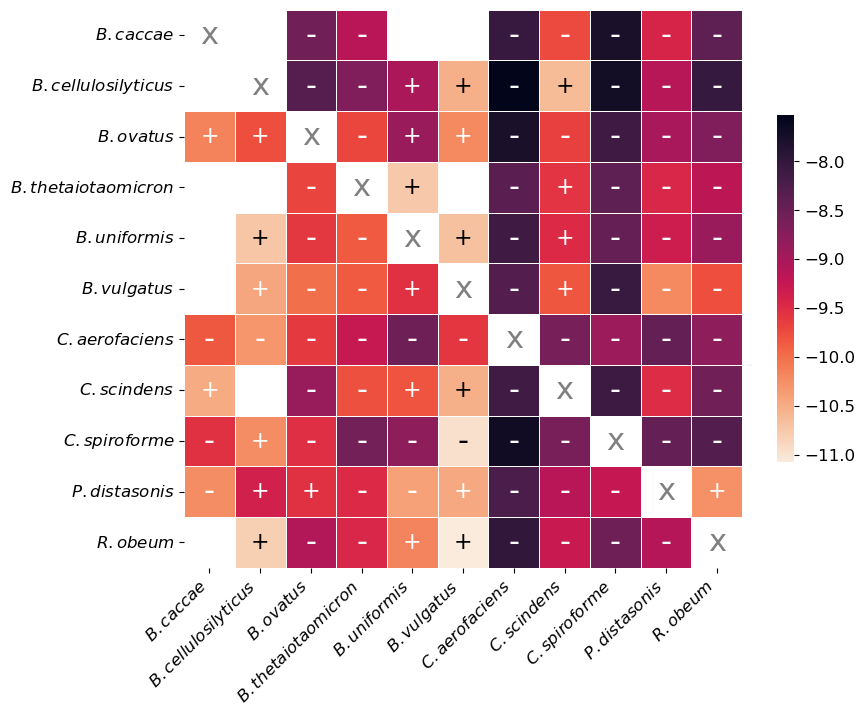

In [6]:
cmap = sns.color_palette("rocket_r", as_cmap=True)
matrix_lf0 = np.log10(np.absolute(masked_lf0))
plt.figure(figsize=(9,9))
heatmap_lf0 = sns.heatmap(matrix_lf0, cmap=cmap, square=True, cbar_kws={"shrink": .5}, linewidths=0.5)
heatmap_lf0.set_xticklabels(heatmap_lf0.get_xticklabels(), rotation=45, ha='right')
for i in range(len(masked_lf0)):
    for j in range(len(masked_lf0)):
        sign_col = 'k'
        if i == j:
            plt.text(j+0.5, i+0.5, 'x', ha='center', va='center', color='gray', fontsize=22)
        elif np.isnan(masked_lf0).iloc[i, j]:
            plt.text(j+0.5, i+0.5, '', ha='center', va='center', fontsize=18)
        elif np.sign(masked_lf0).iloc[i, j] == 1.:
            if matrix_lf0.iloc[i, j] > -10.5:
                sign_col = 'w'
            plt.text(j+0.5, i+0.5, '+', ha='center', va='center', color=sign_col, fontsize=16)
        elif np.sign(masked_lf0).iloc[i, j] == -1.:
            if matrix_lf0.iloc[i, j] > -10.5:
                sign_col = 'w'
            plt.text(j+0.5, i+0.5, '-', ha='center', va='center', color=sign_col, fontsize=22)
plt.savefig('mcnulty-results/mcnulty-LF0-seed96/posteriors/interactions/interaction_matrix.pdf', bbox_inches='tight')
plt.show()

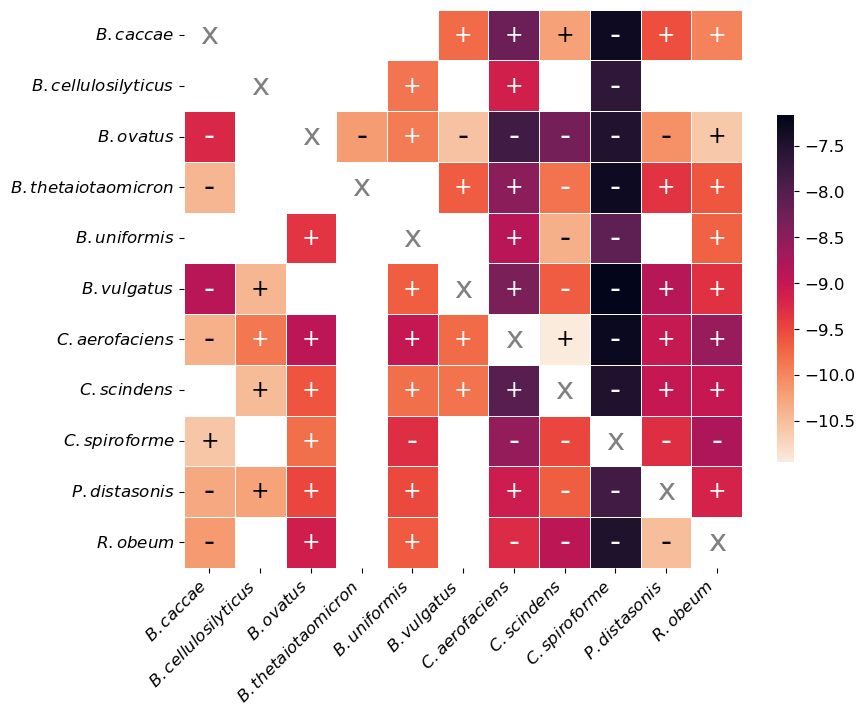

In [7]:
cmap = sns.color_palette("rocket_r", as_cmap=True)
matrix_hf0 = np.log10(np.absolute(masked_hf0))
plt.figure(figsize=(9,9))
heatmap_hf0 = sns.heatmap(matrix_hf0, 
    cmap=cmap, 
    square=True, 
    cbar_kws={"shrink": .5}, 
    linewidths=0.5
    )
heatmap_hf0.set_xticklabels(heatmap_hf0.get_xticklabels(), rotation=45, ha='right')
for i in range(len(masked_hf0)):
    for j in range(len(masked_hf0)):
        sign_col = 'k'
        if i == j:
            plt.text(j+0.5, i+0.5, 'x', ha='center', va='center', color='gray', fontsize=22)
        elif np.isnan(masked_hf0).iloc[i, j]:
            plt.text(j+0.5, i+0.5, '', ha='center', va='center', fontsize=18)
        elif np.sign(masked_hf0).iloc[i, j] == 1.:
            if matrix_hf0.iloc[i, j] > -10:
                sign_col = 'w'
            plt.text(j+0.5, i+0.5, '+', ha='center', va='center', color=sign_col, fontsize=16)
        elif np.sign(masked_hf0).iloc[i, j] == -1.:
            if matrix_hf0.iloc[i, j] > -10:
                sign_col = 'w'
            plt.text(j+0.5, i+0.5, '-', ha='center', va='center', color=sign_col, fontsize=22)
plt.savefig('mcnulty-results/mcnulty-HF0-seed12/posteriors/interactions/interaction_matrix.pdf', bbox_inches='tight')
plt.show()

In [8]:
transformed_interaction_matrix_lf0 = pd.DataFrame(tranform_interaction_matrix(interactions_lf0, inter_bayes_lf0), 
                                                  index=pretty_names, 
                                                  columns=pretty_names)
transformed_interaction_matrix_lf0.to_csv('mcnulty-results/mcnulty-LF0-seed96/posteriors/interactions/mean_matrix_transf.tsv', 
                                            sep='\t', 
                                            index=True, 
                                            header=True)
transformed_interaction_matrix_hf0 = pd.DataFrame(tranform_interaction_matrix(interactions_hf0, inter_bayes_hf0), 
                                                  index=pretty_names, 
                                                  columns=pretty_names)
transformed_interaction_matrix_hf0.to_csv('mcnulty-results/mcnulty-HF0-seed12/posteriors/interactions/mean_matrix_transf.tsv',
                                            sep='\t',
                                            index=True,
                                            header=True)

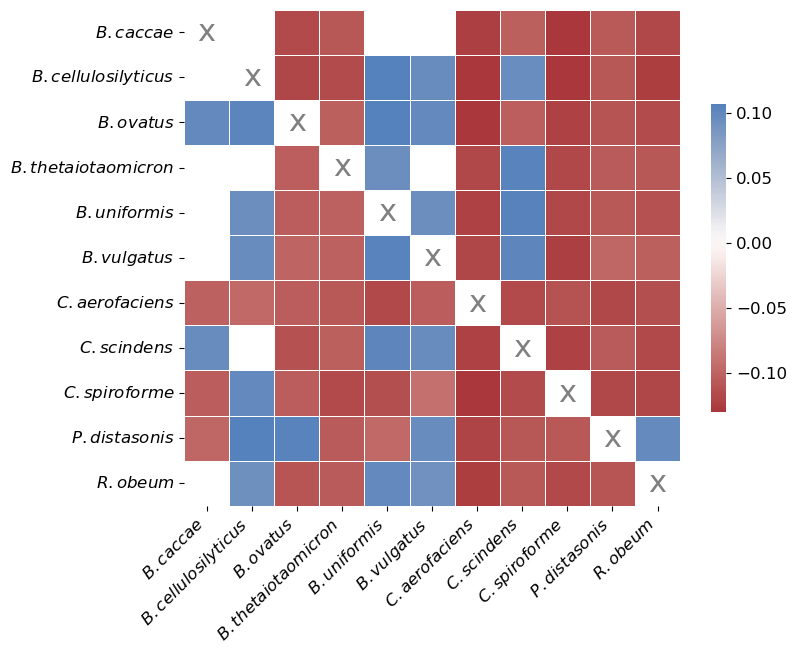

In [9]:
cmap = sns.color_palette("vlag_r", as_cmap=True)
matrix_lf0 = transformed_interaction_matrix_lf0
plt.figure(figsize=(8,8))
heatmap_lf0 = sns.heatmap(matrix_lf0, cmap=cmap, square=True, cbar_kws={"shrink": .5}, linewidths=0.5, robust=True, center=0)
heatmap_lf0.set_xticklabels(heatmap_lf0.get_xticklabels(), rotation=45, ha='right')
for i in range(len(masked_lf0)):
    for j in range(len(masked_lf0)):
        sign_col = 'k'
        if i == j:
            plt.text(j+0.5, i+0.5, 'x', ha='center', va='center', color='gray', fontsize=22)
        elif np.isnan(masked_lf0).iloc[i, j]:
            plt.text(j+0.5, i+0.5, '', ha='center', va='center', fontsize=18)
plt.show()

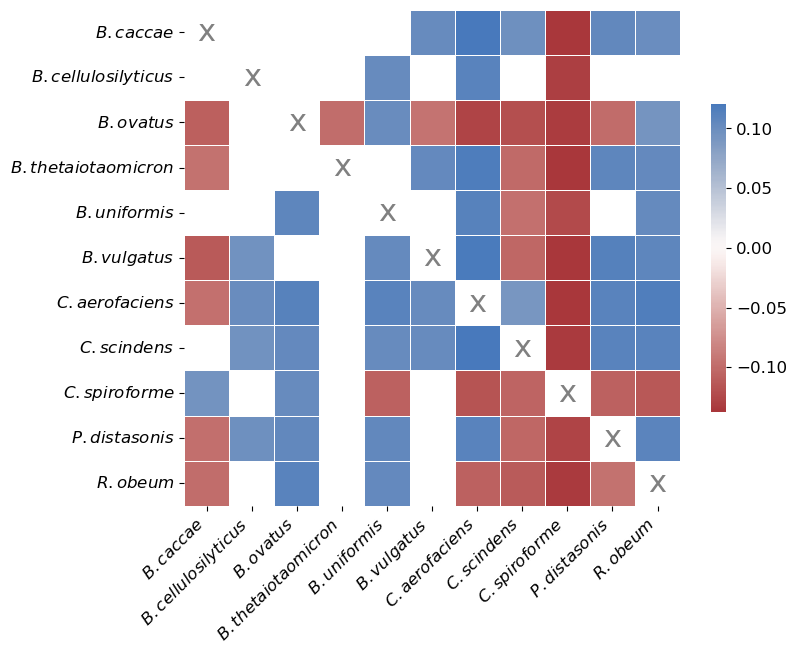

In [10]:
cmap = sns.color_palette("vlag_r", as_cmap=True)
matrix_hf0 = transformed_interaction_matrix_hf0
plt.figure(figsize=(8,8))
heatmap_hf0 = sns.heatmap(matrix_hf0, cmap=cmap, square=True, cbar_kws={"shrink": .5}, linewidths=0.5, robust=True, center=0)
heatmap_hf0.set_xticklabels(heatmap_hf0.get_xticklabels(), rotation=45, ha='right')
for i in range(len(masked_hf0)):
    for j in range(len(masked_hf0)):
        sign_col = 'k'
        if i == j:
            plt.text(j+0.5, i+0.5, 'x', ha='center', va='center', color='gray', fontsize=22)
        elif np.isnan(masked_hf0).iloc[i, j]:
            plt.text(j+0.5, i+0.5, '', ha='center', va='center', fontsize=18)
plt.show()

In [11]:
matrix1 = np.nan_to_num(transformed_interaction_matrix_lf0.values)
matrix2 = np.nan_to_num(transformed_interaction_matrix_hf0.values)

# Procrustes analysis
mtx1_trans, mtx2_trans, disparity = procrustes(matrix1, matrix2)

# Calculate the Procrustes SS
procrustes_ss_mtx1 = disparity**2
procrustes_ss_mtx2 = np.sum((matrix2 - mtx2_trans)**2)

# Perform a permutation test
n_permutations = 10000
permuted_ss = np.zeros(n_permutations)
for i in range(n_permutations):
    _, mtx2_permuted, _ = procrustes(matrix1, np.random.permutation(matrix2))
    permuted_ss[i] = np.sum((matrix2 - mtx2_permuted)**2)

null_disparity = np.zeros(n_permutations)
for i in range(n_permutations):
    # Shuffle the rows of matrix2
    shuffled_matrix2 = matrix2[np.random.permutation(matrix2.shape[0]), :]
    # Run Procrustes analysis on the shuffled matrix
    _, _, null_disparity[i] = procrustes(matrix1, shuffled_matrix2)

# Calculate p-value based on percentile of observed SS value in null distribution
p_value_ss = percentileofscore(permuted_ss, procrustes_ss_mtx2) / 100
# Calculate p-value based on percentile of observed disparity value in null distribution
p_value_disp = percentileofscore(null_disparity, disparity) / 100

# Print the results
print(f"Disparity: {disparity:.4f}")
print(f"Procrustes SS for matrix1: {procrustes_ss_mtx1:.4f}")
print(f"Procrustes SS for matrix2: {procrustes_ss_mtx2:.4f}")
print(f"SS P-value: {p_value_ss:.4f}")
print(f"Disparity P-value: {p_value_disp:.4f}")

Disparity: 0.5166
Procrustes SS for matrix1: 0.2669
Procrustes SS for matrix2: 1.3158
SS P-value: 0.3784
Disparity P-value: 0.1925


In [12]:
permutation_test(matrix1.flatten(), matrix2.flatten(), method='approximate', num_rounds=10000, seed=0, paired=True)

9.999000099990002e-05

In [13]:
difference = np.absolute(np.absolute(transformed_interaction_matrix_lf0) - np.absolute(transformed_interaction_matrix_hf0)) * np.sign(transformed_interaction_matrix_lf0) * np.sign(transformed_interaction_matrix_hf0)
mask = np.isnan(difference)

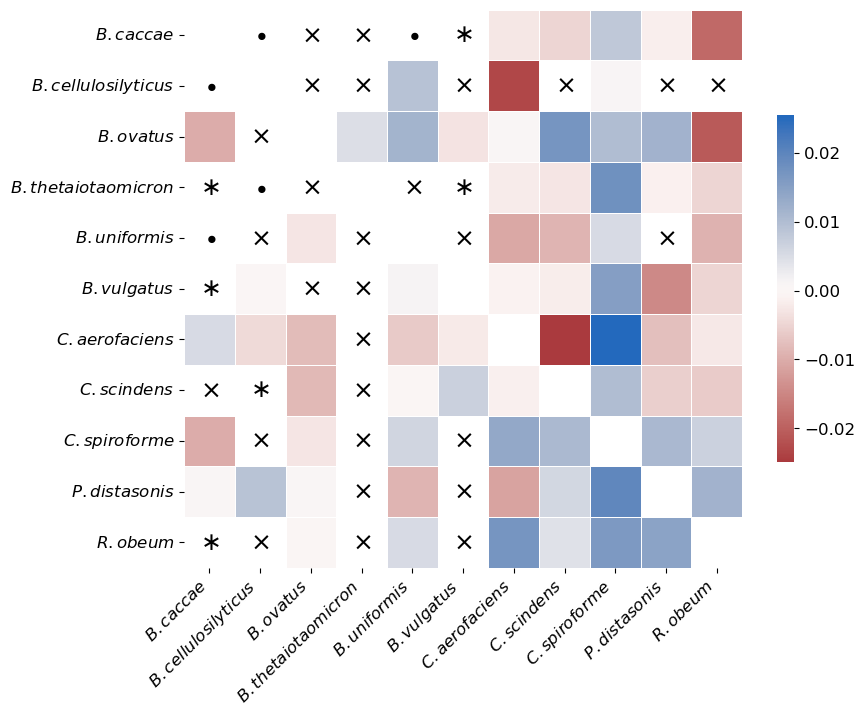

In [14]:
cmap = sns.color_palette("vlag_r", as_cmap=True)
plt.figure(figsize=(9,9))
ax = sns.heatmap(difference.fillna(0), mask = mask, cmap=cmap, center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .5})
for i in range(len(mask)):
    for j in range(len(mask)):
        if i == j:
            plt.text(j+0.5, i+0.5, '', ha='center', va='center', color='gray', fontsize=22)
        elif (np.isnan(transformed_interaction_matrix_lf0).iloc[i, j]) & (not np.isnan(transformed_interaction_matrix_hf0).iloc[i, j]):
            plt.text(j+0.5, i+0.5, '$\\ast$', ha='center', va='center', fontsize=18)
        elif (not np.isnan(transformed_interaction_matrix_lf0).iloc[i, j]) & (np.isnan(transformed_interaction_matrix_hf0).iloc[i, j]):
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', fontsize=18)
        elif (np.isnan(transformed_interaction_matrix_lf0).iloc[i, j]) & (np.isnan(transformed_interaction_matrix_hf0).iloc[i, j]):
            plt.text(j+0.5, i+0.5, '$\\bullet$', ha='center', va='center', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

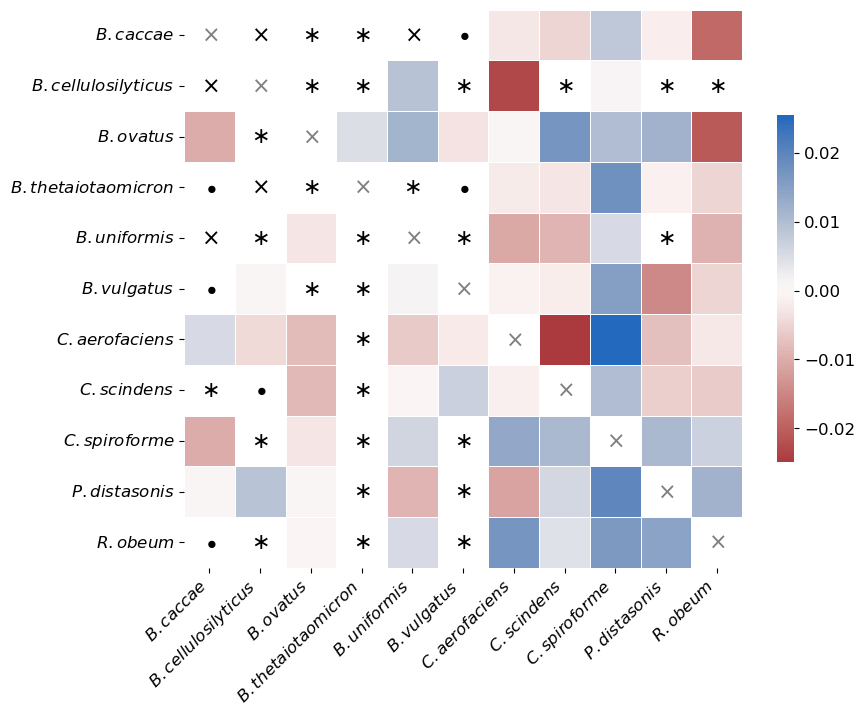

In [15]:
cmap = sns.color_palette("vlag_r", as_cmap=True)
plt.figure(figsize=(9,9))
ax = sns.heatmap(difference.fillna(0), mask = mask, cmap=cmap, center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .5})
for i in range(len(mask)):
    for j in range(len(mask)):
        if i == j:
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', color='gray', fontsize=16)
        elif (np.isnan(transformed_interaction_matrix_lf0).iloc[i, j]) & (not np.isnan(transformed_interaction_matrix_hf0).iloc[i, j]):
            plt.text(j+0.5, i+0.5, '$\\bullet$', ha='center', va='center', fontsize=18)
        elif (not np.isnan(transformed_interaction_matrix_lf0).iloc[i, j]) & (np.isnan(transformed_interaction_matrix_hf0).iloc[i, j]):
            plt.text(j+0.5, i+0.5, '$\\ast$', ha='center', va='center', fontsize=16)
        elif (np.isnan(transformed_interaction_matrix_lf0).iloc[i, j]) & (np.isnan(transformed_interaction_matrix_hf0).iloc[i, j]):
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()